In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import genpareto
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
from random import seed
from random import randint
import seaborn as sns
import time

In [ ]:
#basic

Sweeping through values of v: 100%|█████████████| 21/21 [02:57<00:00,  8.47s/it]


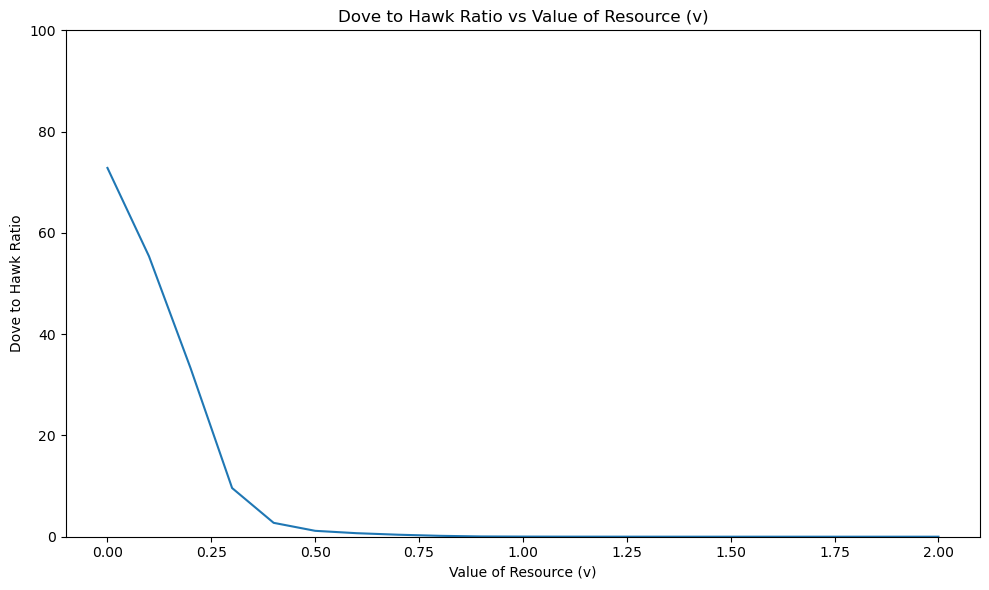

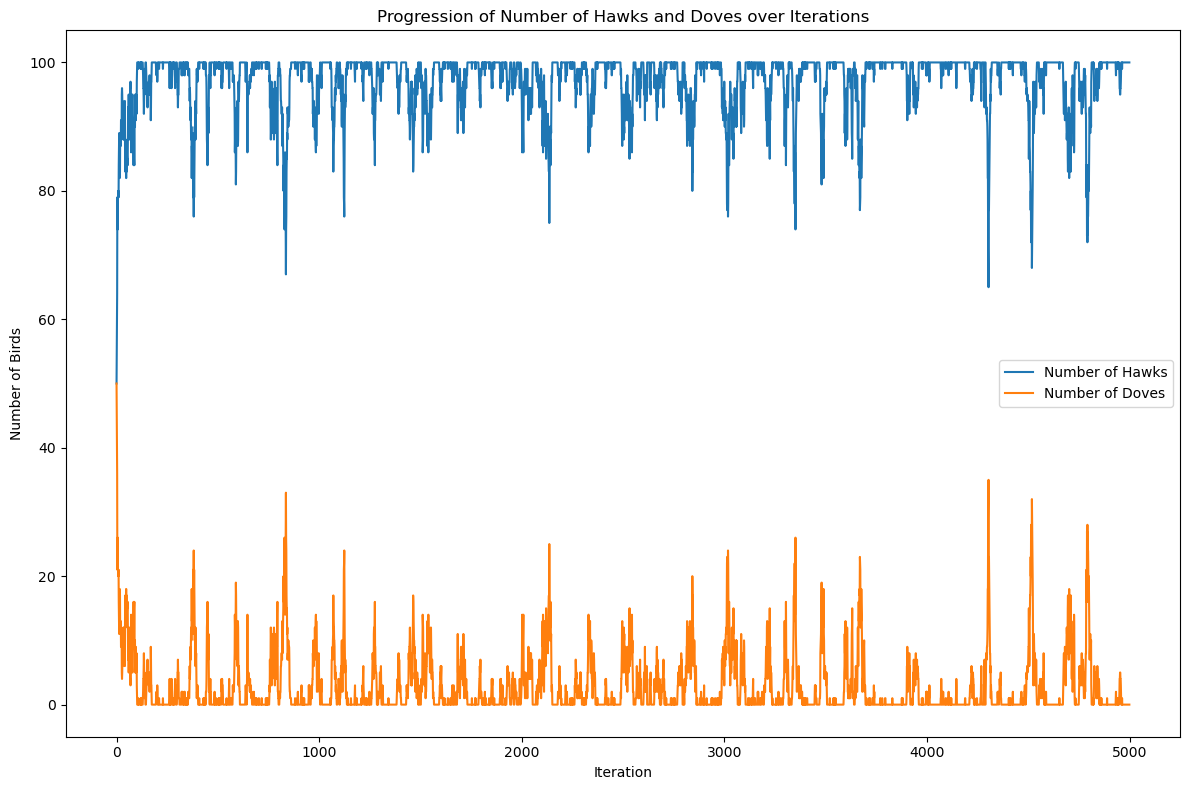

In [98]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

class Bird:
    def __init__(self, strategy, parameters, parent=None):
        self.parent = parent         
        self.parameters = parameters        
        assert strategy in ["hawk", "dove"]
        self.strategy = strategy
        self.fitness = np.random.normal(1, 0)  # Default fitness around 1

    def contest(self, opponent):
        if self.strategy == opponent.strategy == "hawk":
            if random.randint(0, 1) == 1:
                self.fitness += self.parameters.v
                opponent.fitness -= self.parameters.c
            else:
                self.fitness -= self.parameters.c
                opponent.fitness += self.parameters.v
        elif self.strategy == "hawk" and opponent.strategy == "dove":
            self.fitness += self.parameters.v
        elif self.strategy == "dove" and opponent.strategy == "hawk":
            opponent.fitness += self.parameters.v
        else:  # both are doves
            self.fitness += self.parameters.v / 2
            opponent.fitness += self.parameters.v / 2    

        self.fitness = max(self.fitness, 0.001)
        opponent.fitness = max(opponent.fitness, 0.001)
        
    def spawn(self):
        mutation = random.randint(0, 1000) > 999
        new_strategy = "hawk" if (self.strategy == "dove" and mutation) else "dove" if (self.strategy == "hawk" and mutation) else self.strategy
        return Bird(new_strategy, self.parameters, parent=self)

class Parameters:
    """Class to store parameters."""
    def __init__(self, num_agents, v, c, x):
        self.num_agents = num_agents
        self.v = v
        self.c = c
        self.x = x

class Model:
    """A model with some number of agents."""
    def __init__(self, parameters):
        self.parameters = parameters
        self.birds = []
        strategies = ["hawk", "dove"]
        hawk_ratio = 0.5
        dove_ratio = 1 - hawk_ratio
        for _ in range(self.parameters.num_agents):
            strategy = random.choices(strategies, weights=(hawk_ratio, dove_ratio), k=1)
            self.birds.append(Bird(strategy[0], self.parameters))
        self.stats = []

    def full_inheritance(self):
        weights = [bird.fitness for bird in self.birds]
        weights = np.array(weights) / np.sum(weights)
        wf_outcome = random.choices(np.arange(len(self.birds)), weights=weights, k=len(self.birds))
        wf_outcome_counts = np.unique(wf_outcome, return_counts=True)
        
        birds = self.birds
        self.birds = []
        for i in range(len(wf_outcome_counts[1])):
            for j in range(wf_outcome_counts[1][i]):
                self.birds.append(birds[wf_outcome_counts[0][i]].spawn())

    def compute_gini(self):
        agent_fitnesses = [bird.fitness for bird in self.birds]
        x = sorted(agent_fitnesses)
        B = sum(xi * (self.parameters.num_agents - i) for i, xi in enumerate(x)) / (self.parameters.num_agents * sum(x))
        return (1 + (1 / self.parameters.num_agents) - 2 * B)
    
    def record_stats(self):
        strategy = [bird.strategy for bird in self.birds]
        n_hawks = strategy.count("hawk")
        n_doves = strategy.count("dove")
        gini = self.compute_gini()
        record = {'n_hawks': n_hawks, 'n_doves': n_doves, 'gini': gini}
        self.stats.append(record)

    def get_stats(self):
        return pd.DataFrame(self.stats)

    def step(self):
        random.shuffle(self.birds)
        pairs = np.random.choice(self.parameters.num_agents, (int(self.parameters.num_agents / 2), 2), replace=False)
        for pair in pairs:
            self.birds[pair[0]].contest(self.birds[pair[1]])
        self.full_inheritance()

# Parameter sweep with progress bar
parameter_sweep = []

for v in tqdm(np.arange(0, 2.1, 0.1), desc="Sweeping through values of v"):
    for i in range(5):
        parameters = Parameters(num_agents=100, v=v, c=1, x=1)
        model = Model(parameters)
        num_iterations = 5000
        for _ in range(num_iterations):
            model.step()
            strategy = [bird.strategy for bird in model.birds]
            n_hawks = strategy.count("hawk")
            n_doves = strategy.count("dove")
            gini = model.compute_gini()
            record = {'N': parameters.num_agents, 'c': parameters.c, 'v': parameters.v, 'x': parameters.x, 'n_hawks': n_hawks, 'n_doves': n_doves, 'dove_hawk_ratio': n_doves / max(n_hawks, 1)}
            parameter_sweep.append(record)

df = pd.DataFrame(parameter_sweep)

# Plotting
plt.figure(figsize=(10, 6))

# Plot: Dove to Hawk Ratio vs Value of Resource (v)
df.groupby('v')['dove_hawk_ratio'].mean().plot()
plt.title('Dove to Hawk Ratio vs Value of Resource (v)')
plt.xlabel('Value of Resource (v)')
plt.ylabel('Dove to Hawk Ratio')
plt.ylim(0, 100)  # Set the y-axis range between 0 and 100


plt.tight_layout()
plt.savefig('dove_hawk_ratio_vs_value_of_resource.png')  # Save the plot

plt.show()

# Running a single simulation to record the progression of hawks and doves
parameters = Parameters(num_agents=100, v=1, c=1, x=1)
model = Model(parameters)
num_iterations = 5000
progression_stats = []

for _ in range(num_iterations):
    model.step()
    strategy = [bird.strategy for bird in model.birds]
    n_hawks = strategy.count("hawk")
    n_doves = strategy.count("dove")
    record = {'iteration': _, 'n_hawks': n_hawks, 'n_doves': n_doves}
    progression_stats.append(record)

progression_df = pd.DataFrame(progression_stats)

# Plotting the progression of the number of hawks and doves
plt.figure(figsize=(12, 8))

plt.plot(progression_df['iteration'], progression_df['n_hawks'], label='Number of Hawks')
plt.plot(progression_df['iteration'], progression_df['n_doves'], label='Number of Doves')

plt.title('Progression of Number of Hawks and Doves over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Number of Birds')

plt.legend()

plt.tight_layout()

plt.savefig('progression_of_hawks_and_doves.png')  # Save the plot

plt.show()

In [47]:
#inheritance

Running simulations: 100%|████████████████████| 210/210 [09:57<00:00,  2.84s/it]


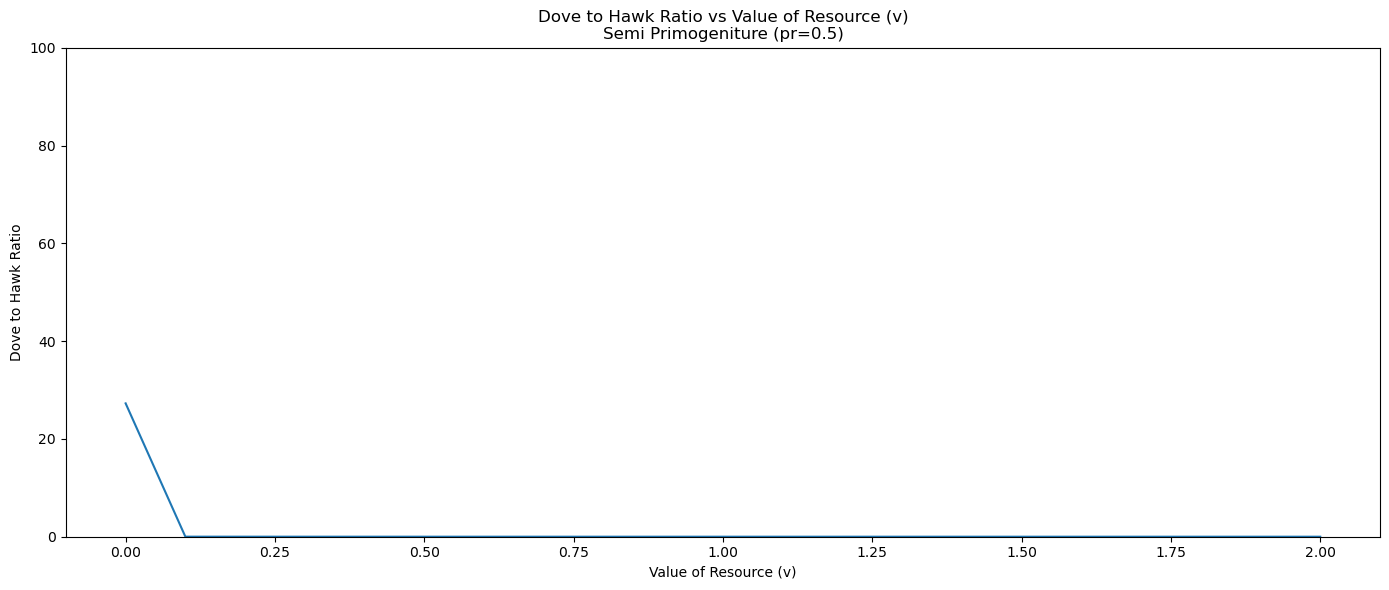

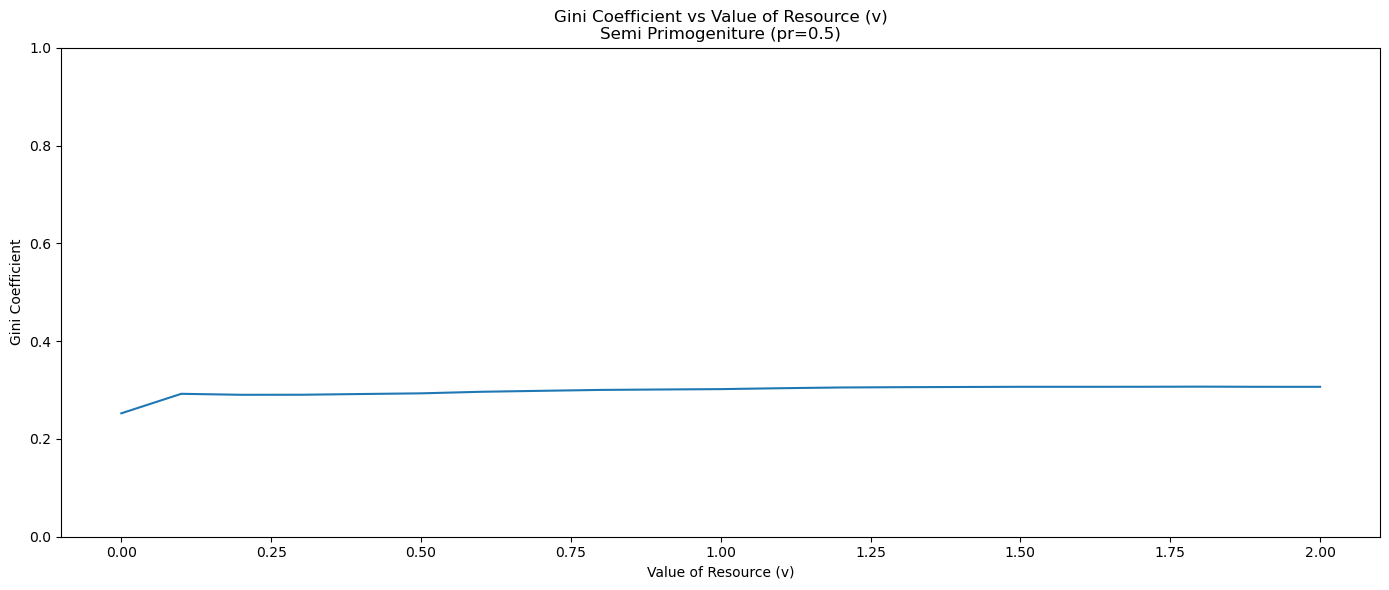

In [96]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

class Bird:
    def __init__(self, strategy, parameters, parent=None, primogenital_inh=None):
        self.parent = parent         
        self.parameters = parameters        
        assert strategy in ["hawk", "dove"]
        self.strategy = strategy
        
        if self.parent is None:
            self.fitness = np.random.normal(self.parameters.fitness_mean, self.parameters.fitness_std_dev)  
        else:
            self.fitness = (self.parent.fitness * primogenital_inh)

    def contest(self, opponent):
        if self.strategy == opponent.strategy == "hawk":
            if random.randint(0, 1) == 1:
                self.fitness += self.parameters.v
                opponent.fitness -= self.parameters.c
            else:
                self.fitness -= self.parameters.c
                opponent.fitness += self.parameters.v
        elif self.strategy == "hawk" and opponent.strategy == "dove":
            self.fitness += self.parameters.v
        elif self.strategy == "dove" and opponent.strategy == "hawk":
            opponent.fitness += self.parameters.v
        else:  # both are doves
            self.fitness += self.parameters.v / 2
            opponent.fitness += self.parameters.v / 2    

        self.fitness = max(self.fitness, 0.001)
        opponent.fitness = max(opponent.fitness, 0.001)
        
    def spawn(self, primogenital_inh):
        mutation = random.randint(0, 1000) > 999
        new_strategy = "hawk" if (self.strategy == "dove" and mutation) else "dove" if (self.strategy == "hawk" and mutation) else self.strategy
        return Bird(new_strategy, self.parameters, parent=self, primogenital_inh=primogenital_inh)

class Parameters:
    """Class to store parameters."""
    def __init__(self, num_agents, c, x, v, pr, fitness_mean, fitness_std_dev):
        self.num_agents = num_agents
        self.c = c
        self.x = x
        self.v = v
        self.pr = pr 
        self.fitness_mean = fitness_mean
        self.fitness_std_dev = fitness_std_dev

class Model:
    """A model with some number of agents."""
    def __init__(self, parameters):
        self.parameters = parameters
        self.birds = []
        strategies = ["hawk", "dove"]
        hawk_ratio = 0.5
        dove_ratio = 1 - hawk_ratio
        for _ in range(self.parameters.num_agents):
            strategy = random.choices(strategies, weights=(hawk_ratio, dove_ratio), k=1)
            self.birds.append(Bird(strategy[0], self.parameters))
        self.stats = []

    def primogenital_inheritance(self):
        for bird in self.birds:
            if bird.fitness <= 0:
                bird.fitness = 0.001
            
        weights = [bird.fitness for bird in self.birds] 
        weights = np.array(weights) / np.sum(weights)
        wf_outcome = np.random.choice(np.arange(len(self.birds)), len(self.birds), replace=True, p=weights)
        wf_outcome_counts = np.unique(wf_outcome, return_counts=True)
        
        birds = self.birds
        self.birds = []
        for i in range(len(wf_outcome_counts[1])):
            for j in range(wf_outcome_counts[1][i]):
                primogenital_inh = 1.0 / wf_outcome_counts[1][i]
                self.birds.append(birds[wf_outcome_counts[0][i]].spawn(primogenital_inh=primogenital_inh))

    def compute_gini(self):
        agent_fitnesses = [bird.fitness for bird in self.birds]
        x = sorted(agent_fitnesses)
        B = sum(xi * (self.parameters.num_agents - i) for i, xi in enumerate(x)) / (self.parameters.num_agents * sum(x))
        return (1 + (1 / self.parameters.num_agents) - 2 * B)
    
    def record_stats(self, iteration):
        strategy = [bird.strategy for bird in self.birds]
        n_hawks = strategy.count("hawk")
        n_doves = strategy.count("dove")
        gini = self.compute_gini()
        record = {'n_hawks': n_hawks, 'n_doves': n_doves, 'gini': gini, 'iteration': iteration}
        self.stats.append(record)

    def get_stats(self):
        return pd.DataFrame(self.stats)

    def step(self, iteration):
        random.shuffle(self.birds)
        for _ in range(self.parameters.num_agents):
            a, b = random.sample(self.birds, 2)
            a.contest(b)  
        self.primogenital_inheritance()
        self.record_stats(iteration)

# Parameter sweep with specific pr value for semi-primogeniture (pr=0.5)
parameter_sweep_semi_0_5 = []

total_iterations = len(np.arange(0, 2.1, 0.1)) * 10

with tqdm(total=total_iterations, desc="Running simulations") as pbar:
    pr = 0.5
    for v in np.arange(0, 2.1, 0.1):
        for i in range(10):
            parameters = Parameters(num_agents=100, v=v, c=1, x=1, pr=pr, fitness_mean=10, fitness_std_dev=0)            
            model_semi = Model(parameters)
            num_iterations = 5000
            for iteration in range(num_iterations):
                model_semi.step(iteration)
                strategy_semi = [bird.strategy for bird in model_semi.birds]
                n_hawks_semi = strategy_semi.count("hawk")
                n_doves_semi = strategy_semi.count("dove")
                gini_semi = model_semi.compute_gini()
                record_semi = {'pr': pr, 'type': 'semi', 'N': parameters.num_agents, 'c': parameters.c, 'v': parameters.v, 'x': parameters.x, 'n_hawks': n_hawks_semi, 'n_doves': n_doves_semi, 'gini': gini_semi, 'iteration': iteration}
                parameter_sweep_semi_0_5.append(record_semi)
            pbar.update(1)

df_semi_0_5 = pd.DataFrame(parameter_sweep_semi_0_5)

# Plotting Dove to Hawk Ratio
plt.figure(figsize=(14, 6))

df_semi_0_5['dove_hawk_ratio'] = df_semi_0_5['n_doves'] / df_semi_0_5['n_hawks'].replace(0, 1)
df_semi_0_5.groupby('v')['dove_hawk_ratio'].mean().plot()
plt.title('Dove to Hawk Ratio vs Value of Resource (v)\nSemi Primogeniture (pr=0.5)')
plt.xlabel('Value of Resource (v)')
plt.ylabel('Dove to Hawk Ratio')
plt.ylim(0, 100)  # Set the y-axis range between 0 and 100

plt.tight_layout()
plt.savefig('inheritance_dove_hawk_ratio.png')  # Save the plot

plt.show()

# Plotting Gini coefficient
plt.figure(figsize=(14, 6))

gini_over_v = df_semi_0_5.groupby('v')['gini'].mean()
plt.plot(gini_over_v.index, gini_over_v.values)
plt.title('Gini Coefficient vs Value of Resource (v)\nSemi Primogeniture (pr=0.5)')
plt.xlabel('Value of Resource (v)')
plt.ylabel('Gini Coefficient')
plt.ylim(0, 1)  # Set the y-axis range between 0 and 1

plt.tight_layout()
plt.savefig('inheritance_gini.png')  # Save the plot

plt.show()

In [49]:
#inheritance + prestige

Running simulations: 100%|████████████████████| 210/210 [10:54<00:00,  3.12s/it]


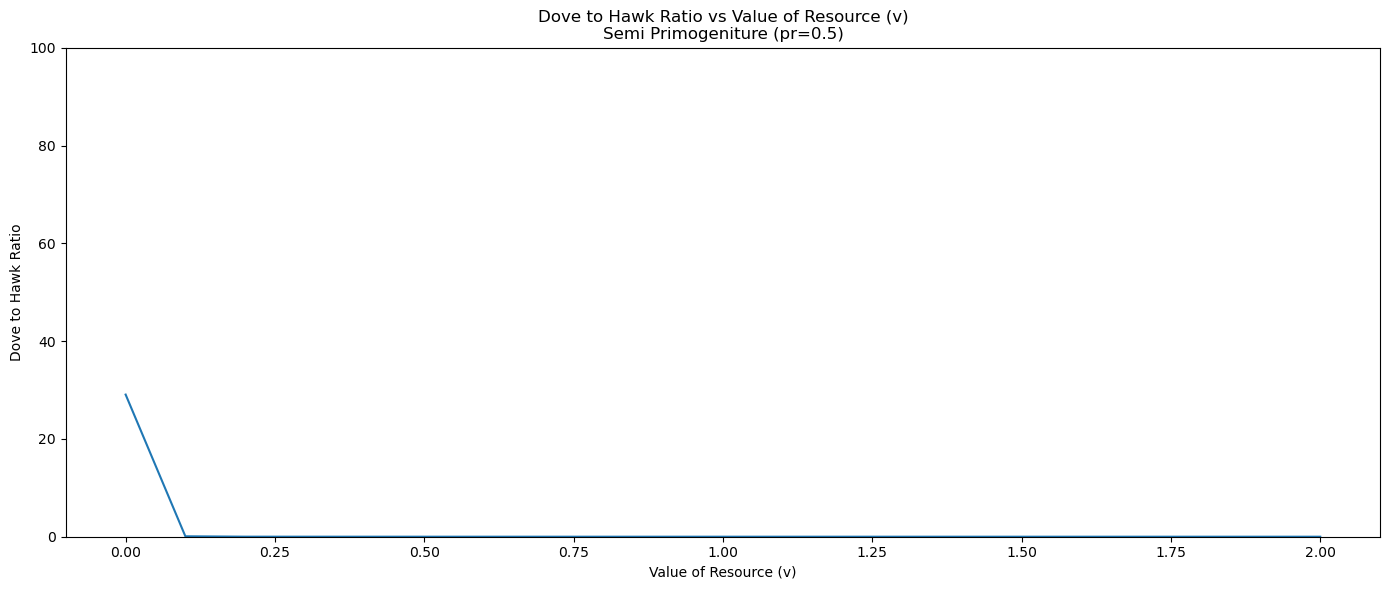

In [100]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

class Bird:
    def __init__(self, strategy, parameters, parent=None, primogenital_inh=None):
        self.parent = parent         
        self.parameters = parameters        
        assert strategy in ["hawk", "dove"]
        self.strategy = strategy
        
        if self.parent is None:
            self.RHP = np.random.normal(self.parameters.RHP_mean, self.parameters.RHP_std_dev)  
        else:
            self.RHP = self.parent.RHP * primogenital_inh
        self.fitness = self.RHP

    def contest(self, opponent):
        self.alpha = self.RHP / (self.RHP + opponent.RHP)
        opponent.alpha = opponent.RHP / (self.RHP + opponent.RHP)
        self.m = self.parameters.x * ((opponent.alpha / (self.alpha + opponent.alpha)) * self.parameters.v)
        opponent.m = self.parameters.x * ((self.alpha / (self.alpha + opponent.alpha)) * self.parameters.v)

        if self.strategy == opponent.strategy == "hawk":
            if self.RHP > opponent.RHP: 
                self.fitness = self.RHP + self.parameters.v - ((opponent.alpha / (self.alpha + opponent.alpha)) * self.parameters.c)
                self.RHP = self.fitness
                opponent.fitness = opponent.RHP - ((self.alpha / (self.alpha + opponent.alpha)) * self.parameters.c)
                opponent.RHP = opponent.fitness
            else:
                self.fitness = self.RHP - ((opponent.alpha / (self.alpha + opponent.alpha)) * self.parameters.c)
                self.RHP = self.fitness
                opponent.fitness = opponent.RHP + self.parameters.v - ((self.alpha / (self.alpha + opponent.alpha)) * self.parameters.c)
                opponent.RHP = opponent.fitness
        elif (self.strategy == "hawk") and (self.strategy != opponent.strategy):
            self.fitness = self.RHP + self.parameters.v
            self.RHP = self.fitness
            opponent.fitness = opponent.RHP
            opponent.RHP = opponent.fitness
        elif (self.strategy == "dove") and (self.strategy != opponent.strategy):
            self.fitness = self.RHP
            self.RHP = self.fitness
            opponent.fitness = opponent.RHP + self.parameters.v
            opponent.RHP = opponent.fitness
        else:  # both are doves
            self.fitness = self.RHP + ((self.alpha / (self.alpha + opponent.alpha)) * self.parameters.v)
            self.RHP = self.fitness
            opponent.fitness = opponent.RHP + ((opponent.alpha / (self.alpha + opponent.alpha)) * self.parameters.v)
            opponent.RHP = opponent.fitness
            if self.RHP > opponent.RHP:     
                self.fitness = self.RHP + self.m
                opponent.fitness = opponent.RHP - self.m
            elif self.RHP == opponent.RHP:
                self.fitness = self.RHP
                opponent.fitness = opponent.RHP
            else:
                self.fitness = self.RHP - opponent.m
                opponent.fitness = opponent.RHP + opponent.m 
        
        self.fitness = max(self.fitness, 0.001)
        opponent.fitness = max(opponent.fitness, 0.001)
        self.RHP = max(self.RHP, 0.001)
        opponent.RHP = max(opponent.RHP, 0.001)
        
    def spawn(self, primogenital_inh):
        mutation = random.randint(0, 1000) > 999
        if mutation:
            new_strategy = "hawk" if self.strategy == "dove" else "dove"
        else:
            new_strategy = self.strategy
        return Bird(new_strategy, self.parameters, parent=self, primogenital_inh=primogenital_inh)

class Parameters:
    def __init__(self, num_agents, c, x, v, pr, RHP_mean, RHP_std_dev):
        self.num_agents = num_agents
        self.c = c
        self.x = x
        self.v = v
        self.pr = pr 
        self.RHP_mean = RHP_mean
        self.RHP_std_dev = RHP_std_dev

class Model:
    def __init__(self, parameters):
        self.parameters = parameters
        self.birds = []
        strategies = ["hawk", "dove"]
        hawk_ratio = 0.5
        dove_ratio = 1 - hawk_ratio
        for _ in range(self.parameters.num_agents):
            strategy = random.choices(strategies, weights=(hawk_ratio, dove_ratio), k=1)[0]
            self.birds.append(Bird(strategy, self.parameters))
        self.stats = []

    def primogenital_inheritance(self):
        for bird in self.birds:
            if bird.fitness <= 0:
                bird.fitness = 0.001
            
        weights = [bird.fitness for bird in self.birds] 
        weights = np.array(weights) / np.sum(weights)
        wf_outcome = np.random.choice(np.arange(len(self.birds)), len(self.birds), replace=True, p=weights)
        wf_outcome_counts = np.unique(wf_outcome, return_counts=True)
        
        birds = self.birds
        self.birds = []
        for i in range(len(wf_outcome_counts[1])):
            for j in range(wf_outcome_counts[1][i]):
                primogenital_inh = 1.0 / wf_outcome_counts[1][i]
                self.birds.append(birds[wf_outcome_counts[0][i]].spawn(primogenital_inh=primogenital_inh))

    def compute_gini(self):
        agent_fitnesses = [bird.fitness for bird in self.birds]
        x = sorted(agent_fitnesses)
        B = sum(xi * (self.parameters.num_agents - i) for i, xi in enumerate(x)) / (self.parameters.num_agents * sum(x))
        return (1 + (1 / self.parameters.num_agents) - 2 * B)
    
    def record_stats(self):
        strategy = [bird.strategy for bird in self.birds]
        n_hawks = strategy.count("hawk")
        n_doves = strategy.count("dove")
        gini = self.compute_gini()
        record = {'n_hawks': n_hawks, 'n_doves': n_doves, 'gini': gini}
        self.stats.append(record)

    def get_stats(self):
        return pd.DataFrame(self.stats)

    def step(self):
        random.shuffle(self.birds)
        for _ in range(self.parameters.num_agents):
            a, b = random.sample(self.birds, 2)
            a.contest(b)  
        self.primogenital_inheritance()

# Parameter sweep with specific pr value for semi-primogeniture (pr=0.5)
parameter_sweep_semi_0_5 = []

total_iterations = len(np.arange(0, 2.1, 0.1)) * 10

with tqdm(total=total_iterations, desc="Running simulations") as pbar:
    pr = 0.5
    for v in np.arange(0, 2.1, 0.1):
        for i in range(10):
            parameters = Parameters(num_agents=100, v=v, c=1, x=1, pr=pr, RHP_mean=10, RHP_std_dev=0)
            model_semi = Model(parameters)
            num_iterations = 5000
            for _ in range(num_iterations):
                model_semi.step()
                strategy_semi = [bird.strategy for bird in model_semi.birds]
                n_hawks_semi = strategy_semi.count("hawk")
                n_doves_semi = strategy_semi.count("dove")
                gini_semi = model_semi.compute_gini()
                record_semi = {'pr': pr, 'type': 'semi', 'N': parameters.num_agents, 'c': parameters.c, 'v': parameters.v, 'x': parameters.x, 'n_hawks': n_hawks_semi, 'n_doves': n_doves_semi, 'gini': gini_semi}
                parameter_sweep_semi_0_5.append(record_semi)
            pbar.update(1)

df_semi_0_5 = pd.DataFrame(parameter_sweep_semi_0_5)

# Plotting
plt.figure(figsize=(14, 6))

# Plot: Dove to Hawk Ratio vs Value of Resource (v) for Semi Primogeniture with pr=0.5
df_semi_0_5['dove_hawk_ratio'] = df_semi_0_5['n_doves'] / df_semi_0_5['n_hawks'].replace(0, 1)
df_semi_0_5.groupby('v')['dove_hawk_ratio'].mean().plot()
plt.title('Dove to Hawk Ratio vs Value of Resource (v)\nSemi Primogeniture (pr=0.5)')
plt.xlabel('Value of Resource (v)')
plt.ylabel('Dove to Hawk Ratio')
plt.ylim(0, 100)  # Set the y-axis range between 0 and 100

plt.tight_layout()
plt.savefig('prestige.png')  # Save the plot

plt.show()

In [51]:
#social learning

Running simulations: 100%|████████████████████| 210/210 [11:09<00:00,  3.19s/it]


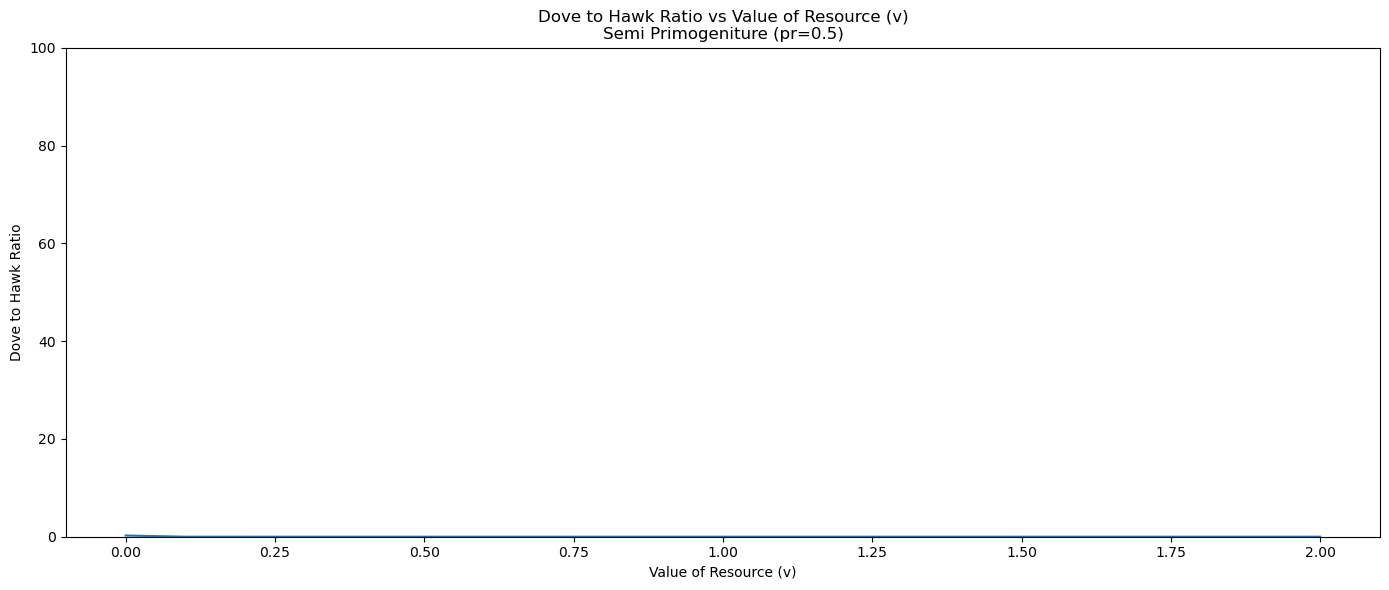

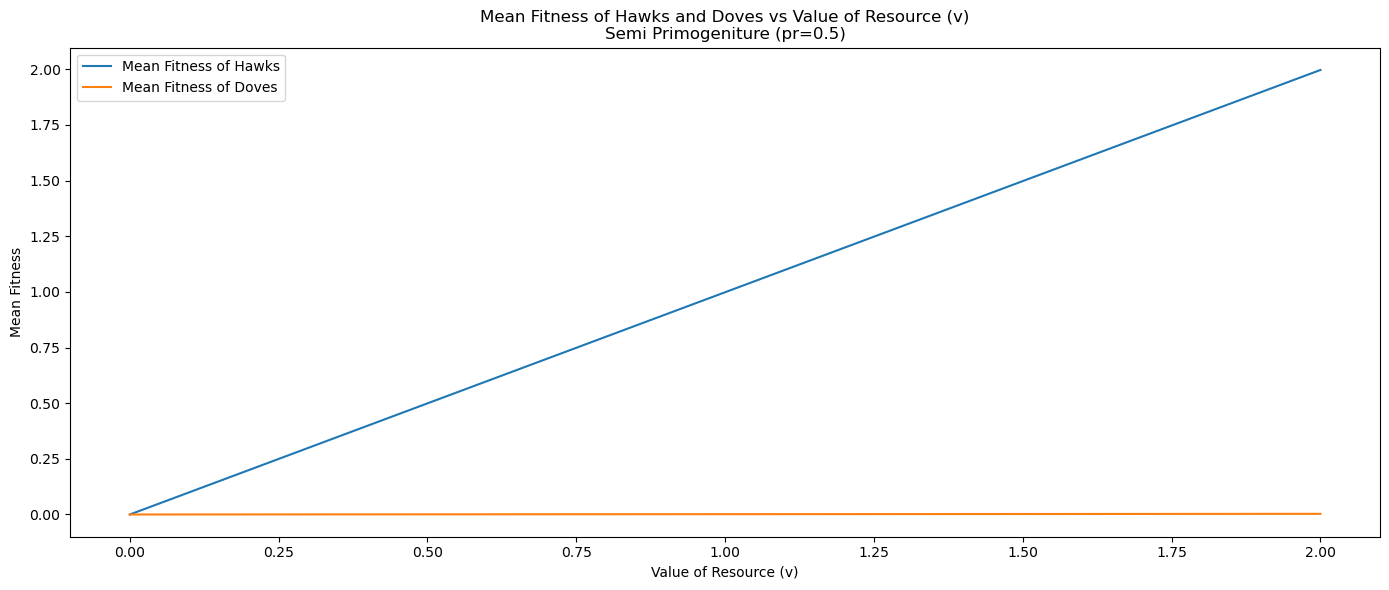

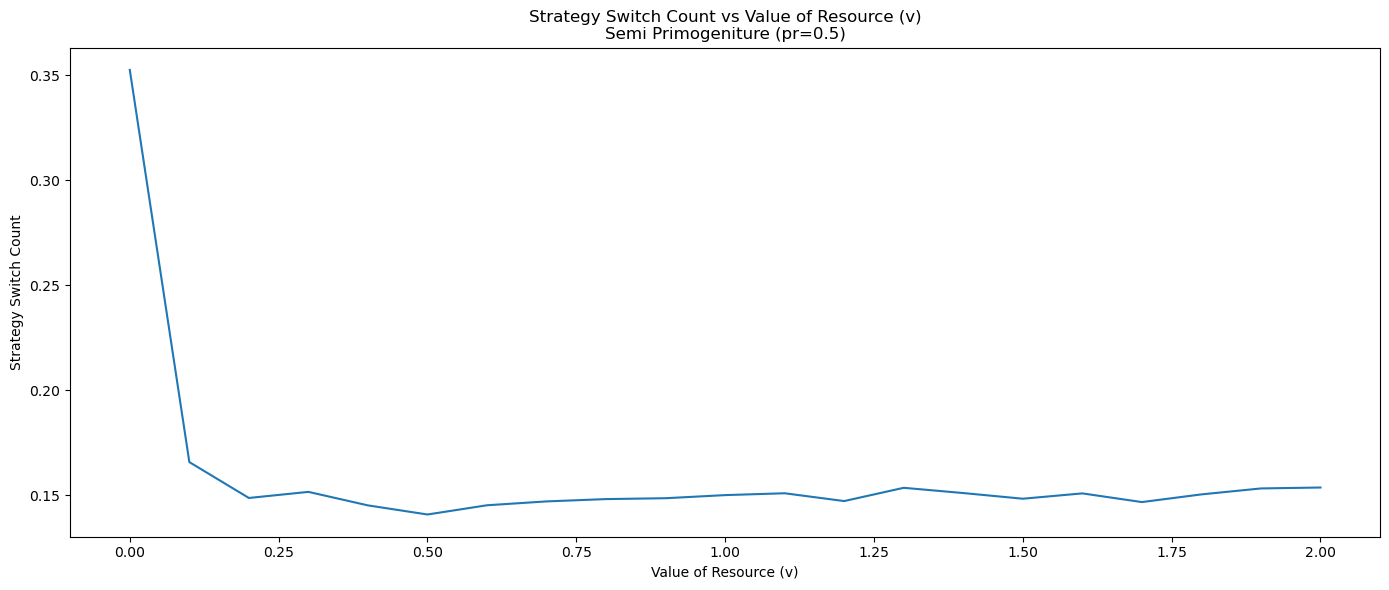

In [21]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

class Bird:
    def __init__(self, strategy, parameters, parent=None, primogenital_inh=None):
        self.parent = parent         
        self.parameters = parameters        
        assert strategy in ["hawk", "dove"]
        self.strategy = strategy
        
        if self.parent is None:
            self.RHP = np.random.normal(self.parameters.RHP_mean, self.parameters.RHP_std_dev)  
            self.fitness = self.RHP
        else:
            self.RHP = self.parent.RHP * primogenital_inh
            self.fitness = self.RHP
            
        if self.fitness <= 0:
            self.fitness = 0.001
        if self.RHP <= 0:
            self.RHP = 0.001

    def contest(self, opponent):
        self.alpha = self.RHP / (self.RHP + opponent.RHP)
        opponent.alpha = opponent.RHP / (self.RHP + opponent.RHP)
        self.m = (((opponent.alpha) / (self.alpha + opponent.alpha)) * self.parameters.v) * self.parameters.x
        opponent.m = (((self.alpha) / (self.alpha + opponent.alpha)) * self.parameters.v) * self.parameters.x

        if self.strategy == opponent.strategy == "hawk":
            if self.RHP > opponent.RHP:
                self.fitness = self.RHP + self.parameters.v - (((opponent.alpha) / (self.alpha + opponent.alpha)) * self.parameters.c)
                self.RHP = self.fitness
                opponent.fitness = opponent.RHP - (((self.alpha) / (self.alpha + opponent.alpha)) * self.parameters.c)
                opponent.RHP = opponent.fitness
            else:
                self.fitness = self.RHP - (((opponent.alpha) / (self.alpha + opponent.alpha)) * self.parameters.c)
                self.RHP = self.fitness
                opponent.fitness = opponent.RHP + self.parameters.v - (((self.alpha) / (self.alpha + opponent.alpha)) * self.parameters.c)
                opponent.RHP = opponent.fitness
        elif (self.strategy == "hawk") and (self.strategy != opponent.strategy):
            self.fitness = self.RHP + self.parameters.v
            self.RHP = self.fitness
            opponent.fitness = opponent.RHP
            opponent.RHP = opponent.fitness
            if opponent.RHP > self.RHP:
                self.strategy = "dove"
            if self.RHP > opponent.RHP:
                opponent.strategy = "hawk"
        elif (self.strategy == "dove") and (self.strategy != opponent.strategy):
            self.fitness = self.RHP
            self.RHP = self.fitness
            opponent.fitness = opponent.RHP + self.parameters.v
            opponent.RHP = opponent.fitness
            if opponent.RHP > self.RHP:
                self.strategy = "hawk"
            if self.RHP > opponent.RHP:
                self.strategy = "dove"
        else:  # both are doves
            self.fitness = self.RHP + (((self.alpha) / (self.alpha + opponent.alpha)) * self.parameters.v)
            self.RHP = self.fitness
            opponent.fitness = opponent.RHP + (((opponent.alpha) / (self.alpha + opponent.alpha)) * self.parameters.v)
            opponent.RHP = opponent.fitness
            if self.RHP > opponent.RHP:
                self.fitness = self.RHP + self.m
                opponent.fitness = opponent.RHP - self.m
            elif self.RHP == opponent.RHP:
                self.fitness = self.RHP
                opponent.fitness = opponent.RHP
            else:
                self.fitness = self.RHP - opponent.m
                opponent.fitness = opponent.RHP + opponent.m

        self.fitness = max(self.fitness, 0.001)
        opponent.fitness = max(opponent.fitness, 0.001)
        self.RHP = max(self.RHP, 0.001)
        opponent.RHP = max(opponent.RHP, 0.001)
        
    def spawn(self, primogenital_inh):
        mutation = random.randint(0, 1000) > 999
        if mutation:
            new_strategy = "hawk" if self.strategy == "dove" else "dove"
        else:
            new_strategy = self.strategy
        return Bird(new_strategy, self.parameters, parent=self, primogenital_inh=primogenital_inh)

class Parameters:
    def __init__(self, num_agents, c, x, v, pr, RHP_mean, RHP_std_dev):
        self.num_agents = num_agents
        self.c = c
        self.x = x
        self.v = v
        self.pr = pr 
        self.RHP_mean = RHP_mean
        self.RHP_std_dev = RHP_std_dev

class Model:
    def __init__(self, parameters):
        self.parameters = parameters
        self.birds = []
        strategies = ["hawk", "dove"]
        hawk_ratio = 0.5
        dove_ratio = 1 - hawk_ratio
        for _ in range(self.parameters.num_agents):
            strategy = random.choices(strategies, weights=(hawk_ratio, dove_ratio), k=1)[0]
            self.birds.append(Bird(strategy, self.parameters))
        self.stats = []

    def primogenital_inheritance(self):
        for bird in self.birds:
            if bird.fitness <= 0:
                bird.fitness = 0.001
            
        weights = [bird.fitness for bird in self.birds] 
        weights = np.array(weights) / np.sum(weights)
        wf_outcome = np.random.choice(np.arange(len(self.birds)), len(self.birds), replace=True, p=weights)
        wf_outcome_counts = np.unique(wf_outcome, return_counts=True)
        
        birds = self.birds
        self.birds = []
        for i in range(len(wf_outcome_counts[1])):
            for j in range(wf_outcome_counts[1][i]):
                primogenital_inh = 1.0 / wf_outcome_counts[1][i]
                self.birds.append(birds[wf_outcome_counts[0][i]].spawn(primogenital_inh=primogenital_inh))

    def compute_gini(self):
        agent_fitnesses = [bird.fitness for bird in self.birds]
        x = sorted(agent_fitnesses)
        B = sum(xi * (self.parameters.num_agents - i) for i, xi in enumerate(x)) / (self.parameters.num_agents * sum(x))
        return (1 + (1 / self.parameters.num_agents) - 2 * B)
    
    def record_stats(self, switch_count):
        strategy = [bird.strategy for bird in self.birds]
        n_hawks = strategy.count("hawk")
        n_doves = strategy.count("dove")
        gini = self.compute_gini()
        record = {'n_hawks': n_hawks, 'n_doves': n_doves, 'gini': gini, 'switch_count': switch_count}
        self.stats.append(record)

    def get_stats(self):
        return pd.DataFrame(self.stats)

    def step(self):
        random.shuffle(self.birds)
        switch_count = 0
        for _ in range(self.parameters.num_agents):
            a, b = random.sample(self.birds, 2)
            a_strategy_before = a.strategy
            b_strategy_before = b.strategy
            a.contest(b)
            if a.strategy != a_strategy_before:
                switch_count += 1
            if b.strategy != b_strategy_before:
                switch_count += 1
        self.primogenital_inheritance()
        self.record_stats(switch_count)

# Parameter sweep with specific pr value for semi-primogeniture (pr=0.5)
parameter_sweep_semi_0_5 = []

total_iterations = len(np.arange(0, 2.1, 0.1)) * 10

with tqdm(total=total_iterations, desc="Running simulations") as pbar:
    pr = 0.5
    for v in np.arange(0, 2.1, 0.1):
        for i in range(10):
            parameters = Parameters(num_agents=100, v=v, c=1, x=1, pr=pr, RHP_mean=10, RHP_std_dev=0)
            model_semi = Model(parameters)
            num_iterations = 5000
            for _ in range(num_iterations):
                model_semi.step()
            stats_semi = model_semi.get_stats()
            stats_semi['v'] = v
            stats_semi['pr'] = pr
            stats_semi['type'] = 'semi'
            parameter_sweep_semi_0_5.append(stats_semi)
            pbar.update(1)

df_semi_0_5_social = pd.concat(parameter_sweep_semi_0_5)

# Plotting
plt.figure(figsize=(14, 6))

# Plot: Dove to Hawk Ratio vs Value of Resource (v) for Semi Primogeniture with pr=0.5
df_semi_0_5_social['dove_hawk_ratio'] = df_semi_0_5_social['n_doves'] / df_semi_0_5_social['n_hawks'].replace(0, 1)
df_semi_0_5_social.groupby('v')['dove_hawk_ratio'].mean().plot()
plt.title('Dove to Hawk Ratio vs Value of Resource (v)\nSemi Primogeniture (pr=0.5)')
plt.xlabel('Value of Resource (v)')
plt.ylabel('Dove to Hawk Ratio')
plt.ylim(0, 100)  # Set the y-axis range between 0 and 100

plt.tight_layout()
plt.savefig('social_learning.png')  # Save the plot

plt.show()

# Additional Plot: Mean Fitness of Hawks and Doves vs Value of Resource (v)
plt.figure(figsize=(14, 6))

# Calculate mean fitness for hawks and doves
df_semi_0_5_social['mean_fitness_hawk'] = df_semi_0_5_social.apply(lambda row: row['n_hawks'] * row['v'] / (row['n_hawks'] + row['n_doves']), axis=1)
df_semi_0_5_social['mean_fitness_dove'] = df_semi_0_5_social.apply(lambda row: row['n_doves'] * row['v'] / (row['n_hawks'] + row['n_doves']), axis=1)

# Plot mean fitness for hawks
df_semi_0_5_social.groupby('v')['mean_fitness_hawk'].mean().plot(label='Mean Fitness of Hawks')
# Plot mean fitness for doves
df_semi_0_5_social.groupby('v')['mean_fitness_dove'].mean().plot(label='Mean Fitness of Doves')

plt.title('Mean Fitness of Hawks and Doves vs Value of Resource (v)\nSemi Primogeniture (pr=0.5)')
plt.xlabel('Value of Resource (v)')
plt.ylabel('Mean Fitness')
plt.legend()

plt.tight_layout()
plt.savefig('social_learning_means.png')  # Save the plot

plt.show()

# Additional Plot: Strategy Switch Count vs Value of Resource (v)
plt.figure(figsize=(14, 6))

# Calculate mean switch count
df_semi_0_5_social.groupby('v')['switch_count'].mean().plot()
plt.title('Strategy Switch Count vs Value of Resource (v)\nSemi Primogeniture (pr=0.5)')
plt.xlabel('Value of Resource (v)')
plt.ylabel('Strategy Switch Count')

plt.tight_layout()
plt.savefig('strategy_switch_count_learning.png')  # Save the plot

plt.show()

In [8]:
#prestige learning

Running simulations: 100%|████████████████████| 210/210 [11:15<00:00,  3.22s/it]


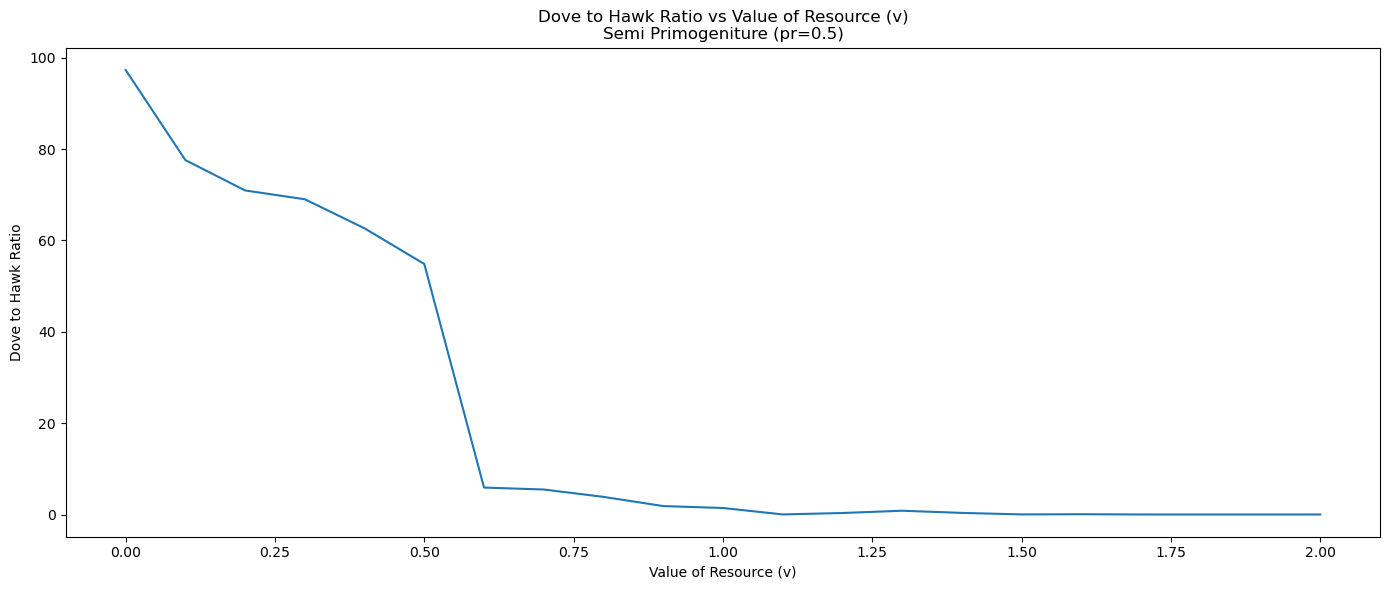

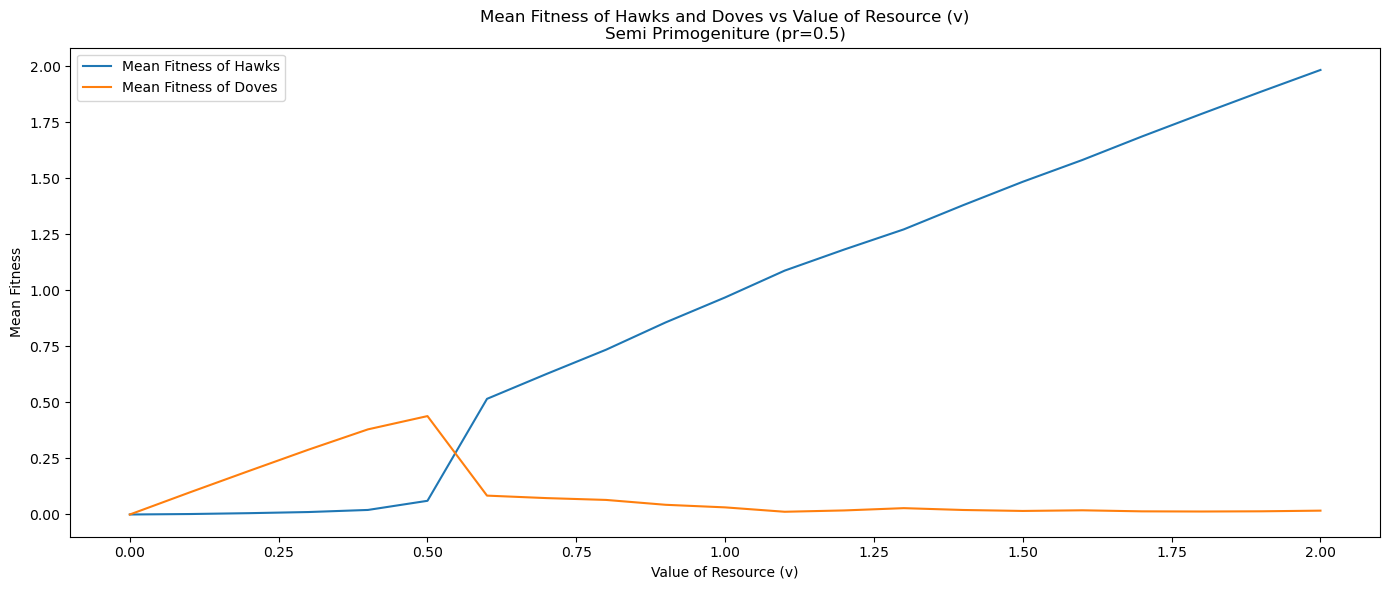

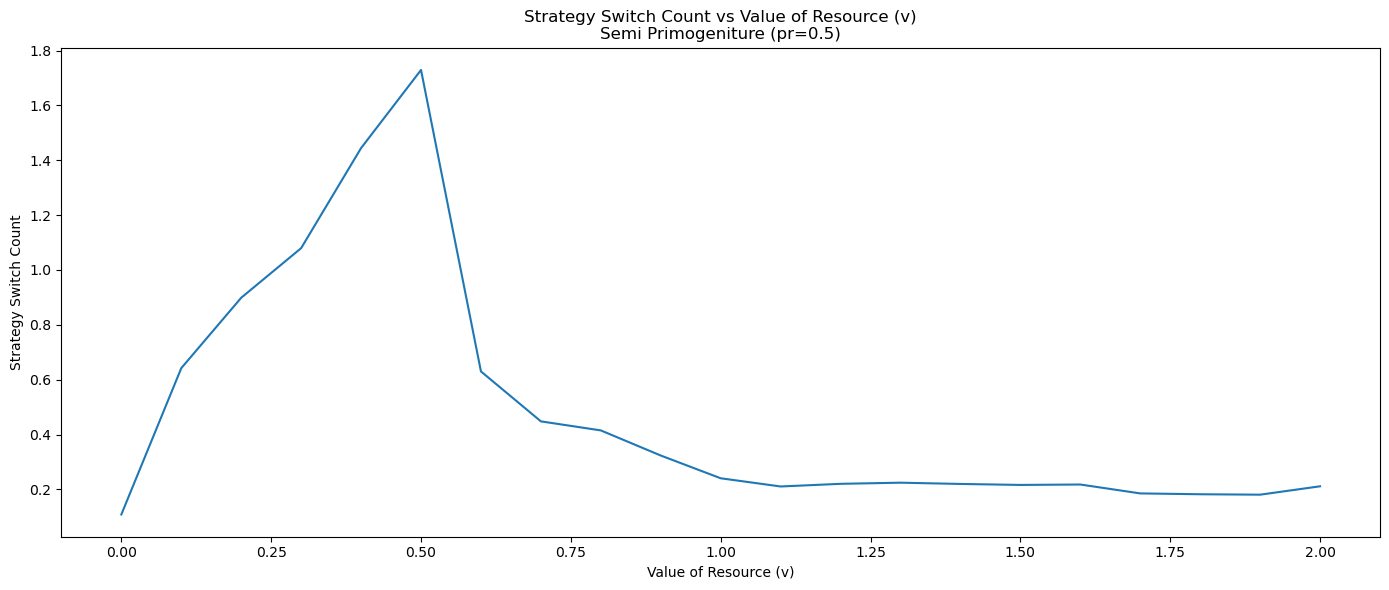

In [22]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

class Bird:
    def __init__(self, strategy, parameters, parent=None, primogenital_inh=None):
        self.parent = parent         
        self.parameters = parameters        
        assert strategy in ["hawk", "dove"]
        self.strategy = strategy
        
        if self.parent is None:
            self.RHP = np.random.normal(self.parameters.RHP_mean, self.parameters.RHP_std_dev)  
            self.fitness = self.RHP
        else:
            self.RHP = self.parent.RHP * primogenital_inh
            self.fitness = self.RHP
            
        if self.fitness <= 0:
            self.fitness = 0.001
        if self.RHP <= 0:
            self.RHP = 0.001

    def contest(self, opponent):
        self.alpha = self.RHP / (self.RHP + opponent.RHP)
        opponent.alpha = opponent.RHP / (self.RHP + opponent.RHP)
        self.m = (((opponent.alpha) / (self.alpha + opponent.alpha)) * self.parameters.v) * self.parameters.x
        opponent.m = (((self.alpha) / (self.alpha + opponent.alpha)) * self.parameters.v) * self.parameters.x

        if self.strategy == opponent.strategy == "hawk":
            if self.RHP > opponent.RHP:
                self.fitness = self.RHP + self.parameters.v - (((opponent.alpha) / (self.alpha + opponent.alpha)) * self.parameters.c)
                self.RHP = self.fitness
                opponent.fitness = opponent.RHP - (((self.alpha) / (self.alpha + opponent.alpha)) * self.parameters.c)
                opponent.RHP = opponent.fitness
            else:
                self.fitness = self.RHP - (((opponent.alpha) / (self.alpha + opponent.alpha)) * self.parameters.c)
                self.RHP = self.fitness
                opponent.fitness = opponent.RHP + self.parameters.v - (((self.alpha) / (self.alpha + opponent.alpha)) * self.parameters.c)
                opponent.RHP = opponent.fitness
        elif (self.strategy == "hawk") and (self.strategy != opponent.strategy):
            self.fitness = self.RHP + self.parameters.v
            self.RHP = self.fitness
            opponent.fitness = opponent.RHP
            opponent.RHP = opponent.fitness
            if opponent.RHP > self.RHP:
                self.strategy = "dove"
        elif (self.strategy == "dove") and (self.strategy != opponent.strategy):
            self.fitness = self.RHP
            self.RHP = self.fitness
            opponent.fitness = opponent.RHP + self.parameters.v
            opponent.RHP = opponent.fitness
            if self.RHP > opponent.RHP:
                opponent.strategy = "dove"
        else:  # both are doves
            self.fitness = self.RHP + (((self.alpha) / (self.alpha + opponent.alpha)) * self.parameters.v)
            self.RHP = self.fitness
            opponent.fitness = opponent.RHP + (((opponent.alpha) / (self.alpha + opponent.alpha)) * self.parameters.v)
            opponent.RHP = opponent.fitness
            if self.RHP > opponent.RHP:
                self.fitness = self.RHP + self.m
                opponent.fitness = opponent.RHP - self.m
            elif self.RHP == opponent.RHP:
                self.fitness = self.RHP
                opponent.fitness = opponent.RHP
            else:
                self.fitness = self.RHP - opponent.m
                opponent.fitness = opponent.RHP + opponent.m

        self.fitness = max(self.fitness, 0.001)
        opponent.fitness = max(opponent.fitness, 0.001)
        self.RHP = max(self.RHP, 0.001)
        opponent.RHP = max(opponent.RHP, 0.001)
        
    def spawn(self, primogenital_inh):
        mutation = random.randint(0, 1000) > 999
        if mutation:
            new_strategy = "hawk" if self.strategy == "dove" else "dove"
        else:
            new_strategy = self.strategy
        return Bird(new_strategy, self.parameters, parent=self, primogenital_inh=primogenital_inh)

class Parameters:
    def __init__(self, num_agents, c, x, v, pr, RHP_mean, RHP_std_dev):
        self.num_agents = num_agents
        self.c = c
        self.x = x
        self.v = v
        self.pr = pr 
        self.RHP_mean = RHP_mean
        self.RHP_std_dev = RHP_std_dev

class Model:
    def __init__(self, parameters):
        self.parameters = parameters
        self.birds = []
        strategies = ["hawk", "dove"]
        hawk_ratio = 0.5
        dove_ratio = 1 - hawk_ratio
        for _ in range(self.parameters.num_agents):
            strategy = random.choices(strategies, weights=(hawk_ratio, dove_ratio), k=1)[0]
            self.birds.append(Bird(strategy, self.parameters))
        self.stats = []

    def primogenital_inheritance(self):
        for bird in self.birds:
            if bird.fitness <= 0:
                bird.fitness = 0.001
            
        weights = [bird.fitness for bird in self.birds] 
        weights = np.array(weights) / np.sum(weights)
        wf_outcome = np.random.choice(np.arange(len(self.birds)), len(self.birds), replace=True, p=weights)
        wf_outcome_counts = np.unique(wf_outcome, return_counts=True)
        
        birds = self.birds
        self.birds = []
        for i in range(len(wf_outcome_counts[1])):
            for j in range(wf_outcome_counts[1][i]):
                primogenital_inh = 1.0 / wf_outcome_counts[1][i]
                self.birds.append(birds[wf_outcome_counts[0][i]].spawn(primogenital_inh=primogenital_inh))

    def compute_gini(self):
        agent_fitnesses = [bird.fitness for bird in self.birds]
        x = sorted(agent_fitnesses)
        B = sum(xi * (self.parameters.num_agents - i) for i, xi in enumerate(x)) / (self.parameters.num_agents * sum(x))
        return (1 + (1 / self.parameters.num_agents) - 2 * B)
    
    def record_stats(self, switch_count):
        strategy = [bird.strategy for bird in self.birds]
        n_hawks = strategy.count("hawk")
        n_doves = strategy.count("dove")
        gini = self.compute_gini()
        record = {'n_hawks': n_hawks, 'n_doves': n_doves, 'gini': gini, 'switch_count': switch_count}
        self.stats.append(record)

    def get_stats(self):
        return pd.DataFrame(self.stats)

    def step(self):
        random.shuffle(self.birds)
        switch_count = 0
        for _ in range(self.parameters.num_agents):
            a, b = random.sample(self.birds, 2)
            a_strategy_before = a.strategy
            b_strategy_before = b.strategy
            a.contest(b)
            if a.strategy != a_strategy_before:
                switch_count += 1
            if b.strategy != b_strategy_before:
                switch_count += 1
        self.primogenital_inheritance()
        self.record_stats(switch_count)

# Parameter sweep with specific pr value for semi-primogeniture (pr=0.5)
parameter_sweep_semi_0_5 = []

total_iterations = len(np.arange(0, 2.1, 0.1)) * 10

with tqdm(total=total_iterations, desc="Running simulations") as pbar:
    pr = 0.5
    for v in np.arange(0, 2.1, 0.1):
        for i in range(10):
            parameters = Parameters(num_agents=100, v=v, c=1, x=1, pr=pr, RHP_mean=10, RHP_std_dev=0)
            model_semi = Model(parameters)
            num_iterations = 5000
            for _ in range(num_iterations):
                model_semi.step()
            stats_semi = model_semi.get_stats()
            stats_semi['v'] = v
            stats_semi['pr'] = pr
            stats_semi['type'] = 'semi'
            parameter_sweep_semi_0_5.append(stats_semi)
            pbar.update(1)

df_semi_0_5_prestige = pd.concat(parameter_sweep_semi_0_5)

# Plot: Dove to Hawk Ratio vs Value of Resource (v) for Semi Primogeniture with pr=0.5
plt.figure(figsize=(14, 6))
df_semi_0_5_prestige['dove_hawk_ratio'] = df_semi_0_5_prestige['n_doves'] / df_semi_0_5_prestige['n_hawks'].replace(0, 1)
df_semi_0_5_prestige.groupby('v')['dove_hawk_ratio'].mean().plot()
plt.title('Dove to Hawk Ratio vs Value of Resource (v)\nSemi Primogeniture (pr=0.5)')
plt.xlabel('Value of Resource (v)')
plt.ylabel('Dove to Hawk Ratio')
plt.tight_layout()
plt.savefig('prestige_learning.png')  # Save the plot
plt.show()

# Additional Plot: Mean Fitness of Hawks and Doves vs Value of Resource (v)
plt.figure(figsize=(14, 6))
df_semi_0_5_prestige['mean_fitness_hawk'] = df_semi_0_5_prestige.apply(lambda row: (row['n_hawks'] * row['v']) / (row['n_hawks'] + row['n_doves']), axis=1)
df_semi_0_5_prestige['mean_fitness_dove'] = df_semi_0_5_prestige.apply(lambda row: (row['n_doves'] * row['v']) / (row['n_hawks'] + row['n_doves']), axis=1)
df_semi_0_5_prestige.groupby('v')['mean_fitness_hawk'].mean().plot(label='Mean Fitness of Hawks')
df_semi_0_5_prestige.groupby('v')['mean_fitness_dove'].mean().plot(label='Mean Fitness of Doves')
plt.title('Mean Fitness of Hawks and Doves vs Value of Resource (v)\nSemi Primogeniture (pr=0.5)')
plt.xlabel('Value of Resource (v)')
plt.ylabel('Mean Fitness')
plt.legend()
plt.tight_layout()
plt.savefig('prestige_learning_means.png')  # Save the plot
plt.show()

# Additional Plot: Strategy Switch Count vs Value of Resource (v)
plt.figure(figsize=(14, 6))
df_semi_0_5_prestige.groupby('v')['switch_count'].mean().plot()
plt.title('Strategy Switch Count vs Value of Resource (v)\nSemi Primogeniture (pr=0.5)')
plt.xlabel('Value of Resource (v)')
plt.ylabel('Strategy Switch Count')
plt.tight_layout()
plt.savefig('strategy_switch_count_prestige_learning.png')  # Save the plot
plt.show()

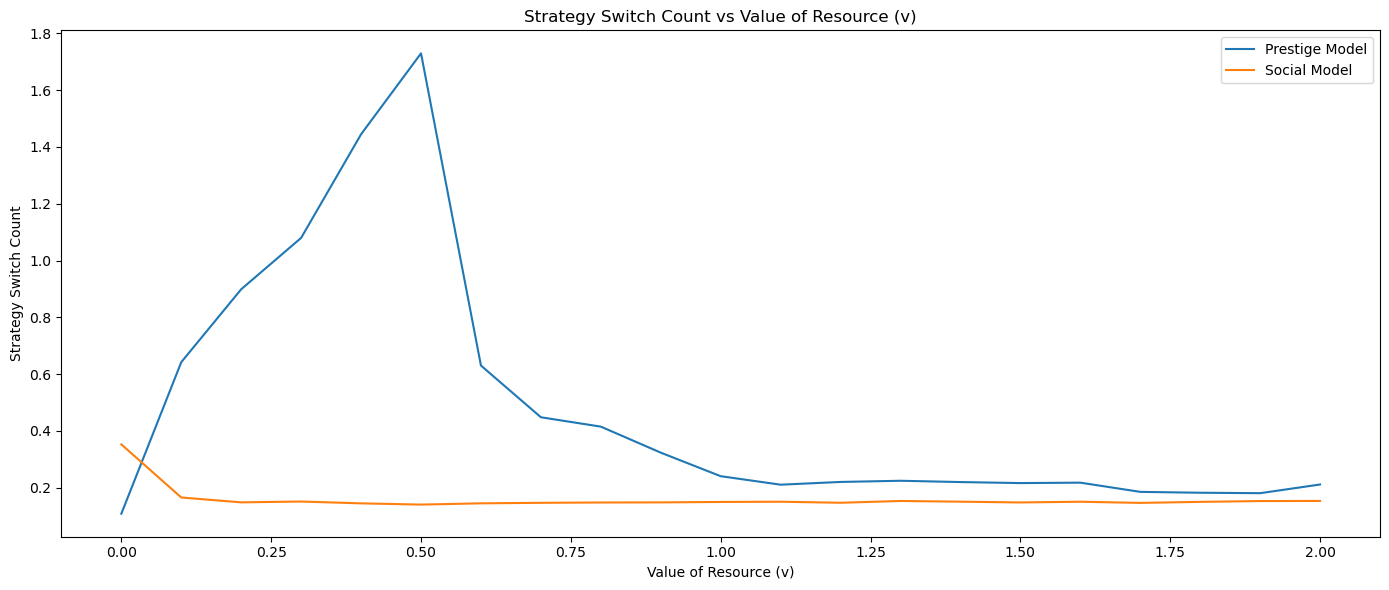

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_semi_0_5_prestige and df_semi_0_5_social have been created as in the original code
# You can load them from CSV or another source if they were saved

# Calculate mean overall RHPs for each dataframe
df_semi_0_5_prestige['mean_overall_rhp'] = df_semi_0_5_prestige.apply(lambda row: (row['n_hawks'] * row['v'] + row['n_doves'] * row['v']) / (row['n_hawks'] + row['n_doves']), axis=1)
df_semi_0_5_social['mean_overall_rhp'] = df_semi_0_5_social.apply(lambda row: (row['n_hawks'] * row['v'] + row['n_doves'] * row['v']) / (row['n_hawks'] + row['n_doves']), axis=1)

# Plot: Strategy Switch Count vs Value of Resource (v)
plt.figure(figsize=(14, 6))

df_semi_0_5_prestige.groupby('v')['switch_count'].mean().plot(label='Prestige Model')
df_semi_0_5_social.groupby('v')['switch_count'].mean().plot(label='Social Model')

plt.title('Strategy Switch Count vs Value of Resource (v)')
plt.xlabel('Value of Resource (v)')
plt.ylabel('Strategy Switch Count')
plt.legend()
plt.tight_layout()
plt.savefig('strategy_switch_count_combined.png')  # Save the plot
plt.show()


In [ ]:
#coalitions

Running simulations: 100%|████████████████████| 210/210 [25:41<00:00,  7.34s/it]


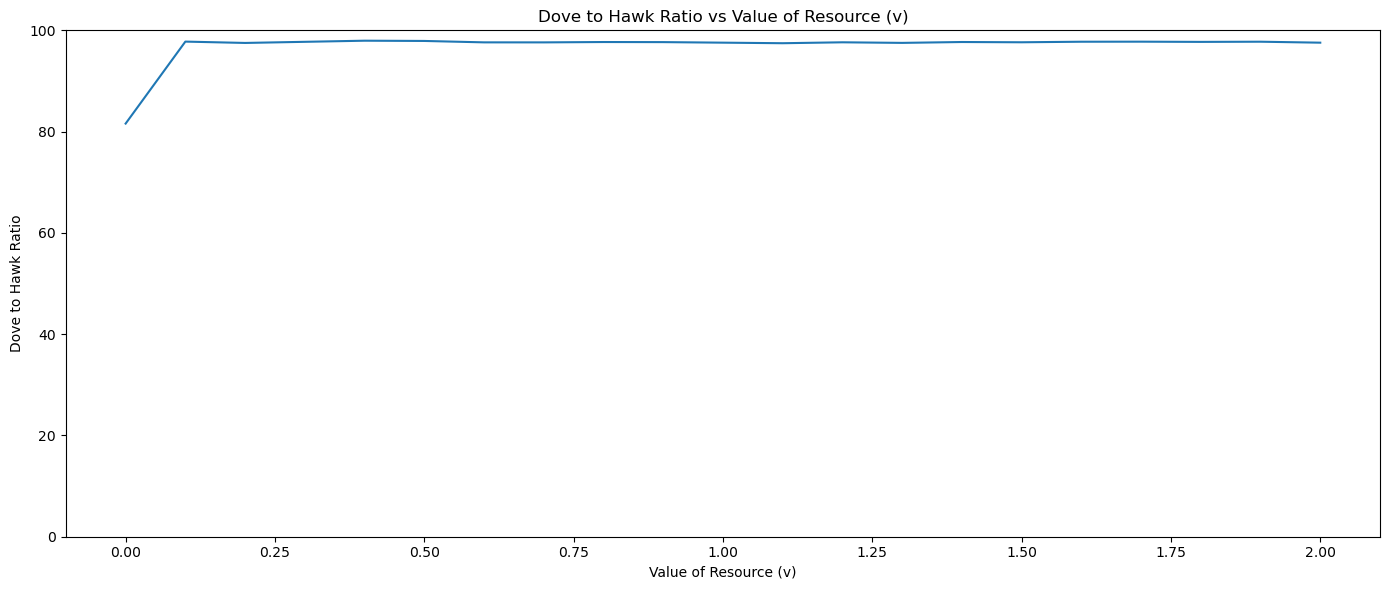

<function matplotlib.pyplot.savefig(*args, **kwargs)>

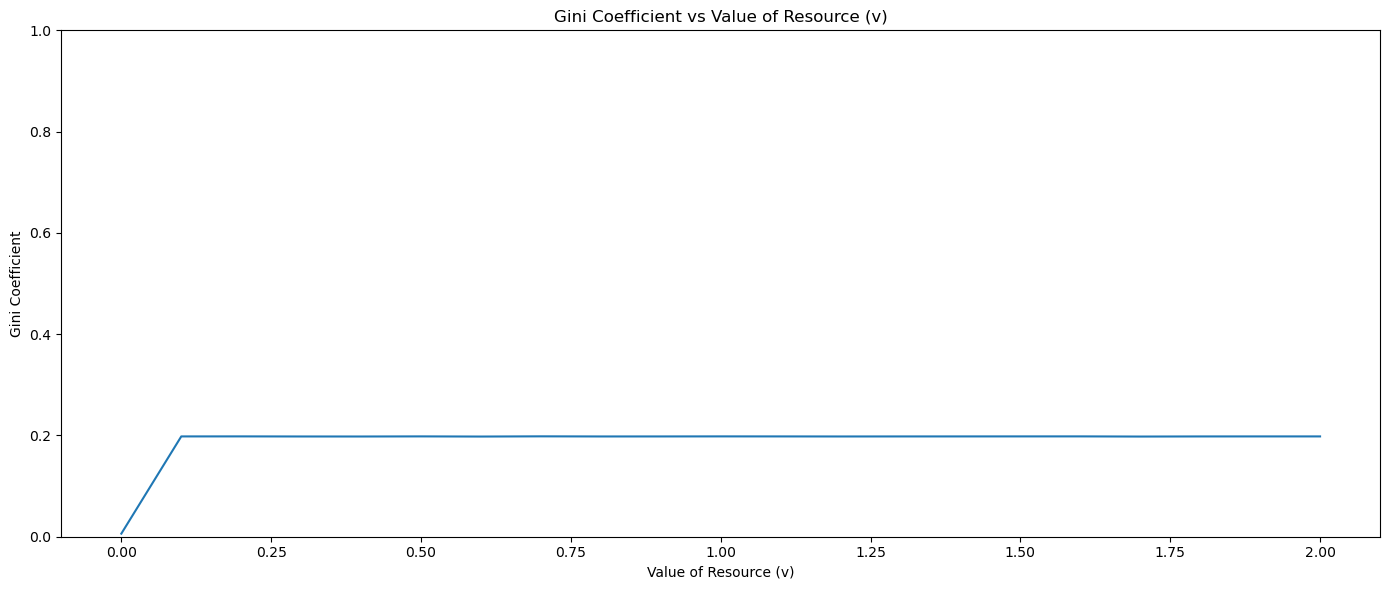

In [104]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics

class Bird:
    def __init__(self, strategy, parameters, parent=None, primogenital_inh=None):
        self.parent = parent         
        self.parameters = parameters        
        assert strategy in ["hawk", "dove"]
        self.strategy = strategy
        
        if self.parent is None:
            self.v = np.random.normal(self.parameters.v_mean, self.parameters.v_std_dev)  
        else:
            self.v = np.random.normal(self.parameters.v_mean, 0) + (self.parent.v * primogenital_inh)

        self.v = max(self.v, 0.001)
        
    def contest(self, opponent, partner):
        total_v = self.v + opponent.v
        self.alpha = self.v / total_v if total_v != 0 else 0
        opponent.alpha = opponent.v / total_v if total_v != 0 else 0
        
        if self.strategy == opponent.strategy == "hawk":
            if self.v > opponent.v: 
                self.v = self.v - ((opponent.alpha / (self.alpha + opponent.alpha)) * self.parameters.c) + opponent.v
                opponent.v = -((self.alpha / (self.alpha + opponent.alpha)) * self.parameters.c)
            else:
                self.v = -((opponent.alpha / (self.alpha + opponent.alpha)) * self.parameters.c)
                opponent.v = opponent.v - ((self.alpha / (self.alpha + opponent.alpha)) * self.parameters.c) + self.v
        elif self.strategy == "dove" and self.strategy != opponent.strategy:
            if partner is None:
                opponent.v += self.v
                self.v = 0
            else:
                if self.v + partner.v > opponent.v:
                    self.v += opponent.v / 2
                    partner.v += opponent.v / 2
                    opponent.v = 0
                else:
                    opponent.v += self.v
                    self.v = 0
        else:
            total_v = self.v + opponent.v
            self.v = (self.alpha / (self.alpha + opponent.alpha)) * total_v
            opponent.v = (opponent.alpha / (self.alpha + opponent.alpha)) * total_v
            
        self.v = max(self.v, 0.001)
        opponent.v = max(opponent.v, 0.001)
        if partner is not None:
            partner.v = max(partner.v, 0.001)
        
    def spawn(self, primogenital_inh):
        mutation = random.random() > 0.999
        new_strategy = "hawk" if self.strategy == "dove" and mutation else "dove" if self.strategy == "hawk" and mutation else self.strategy
        return Bird(new_strategy, self.parameters, parent=self, primogenital_inh=primogenital_inh)

class Parameters:
    def __init__(self, num_agents, c, v_mean, v_std_dev):
        self.num_agents = num_agents
        self.c = c
        self.v_mean = v_mean
        self.v_std_dev = v_std_dev

class Model:
    def __init__(self, parameters):
        self.parameters = parameters
        self.birds = []
        strategies = ["hawk", "dove"]
        hawk_ratio = 0.5
        dove_ratio = 1 - hawk_ratio

        for _ in range(self.parameters.num_agents):
            strategy = random.choices(strategies, weights=(hawk_ratio, dove_ratio), k=1)[0]
            self.birds.append(Bird(strategy, self.parameters))

        self.stats = []

    def primogenital_inheritance(self):
        for bird in self.birds:
            if bird.v <= 0:
                bird.v = 0.001

        weights = np.array([bird.v for bird in self.birds])
        weights_sum = np.sum(weights)
        if weights_sum == 0:
            weights = np.ones(len(self.birds)) / len(self.birds)
        else:
            weights /= weights_sum
        wf_outcome = np.random.choice(len(self.birds), len(self.birds), replace=True, p=weights)
        wf_outcome_counts = np.unique(wf_outcome, return_counts=True)
        
        birds = self.birds
        self.birds = []
        for i in range(len(wf_outcome_counts[1])):
            for j in range(wf_outcome_counts[1][i]):
                if j == 0 and wf_outcome_counts[1][i] > 1:
                    primogenital_inh = 0.5
                elif j == 0:
                    primogenital_inh = 1
                else:
                    denom = wf_outcome_counts[1][i] - 1
                    primogenital_inh = 0.5 / denom if denom != 0 else 0
                self.birds.append(birds[wf_outcome_counts[0][i]].spawn(primogenital_inh=primogenital_inh))
           
    def compute_gini(self):
        agent_vs = [bird.v for bird in self.birds]
        if np.sum(agent_vs) == 0:
            return 0
        x = sorted(agent_vs)
        B = sum(xi * (self.parameters.num_agents - i) for i, xi in enumerate(x)) / (self.parameters.num_agents * sum(x))
        return (1 + (1 / self.parameters.num_agents) - 2 * B)
    
    def compute_mean(self):
        agent_vs = [bird.v for bird in self.birds]
        return statistics.mean(agent_vs) if agent_vs else 0
   
    def record_stats(self):
        strategy = [bird.strategy for bird in self.birds]
        n_hawks = strategy.count("hawk")
        n_doves = strategy.count("dove")
        gini = self.compute_gini()
        mean = self.compute_mean()
        record = {'n_hawks': n_hawks, 'n_doves': n_doves, 'gini': gini, 'mean': mean}
        self.stats.append(record)
        
    def get_stats(self):
        return pd.DataFrame(self.stats)

    def step(self):
        random.shuffle(self.birds)
        
        dove_idx_list = [idx for idx, bird in enumerate(self.birds) if bird.strategy == "dove"]

        for _ in range(self.parameters.num_agents):
            contest_self_idx, contest_opponent_idx = random.sample(range(len(self.birds)), 2)
            
            partner_order = np.random.choice(dove_idx_list, len(dove_idx_list), replace=False)
            contest_partner = None
            for partner_test_idx in partner_order:
                if partner_test_idx != contest_self_idx and partner_test_idx != contest_opponent_idx:
                    contest_partner = self.birds[partner_test_idx]
                    break
            self.birds[contest_self_idx].contest(self.birds[contest_opponent_idx], contest_partner)
        
        self.primogenital_inheritance()

# Running simulations
parameter_sweep = []

total_iterations = len(np.arange(0, 2.1, 0.1)) * 10

with tqdm(total=total_iterations, desc="Running simulations") as pbar:
    for v in np.arange(0, 2.1, 0.1):
        for i in range(10):
            parameters = Parameters(num_agents=100, c=1, v_mean=v, v_std_dev=0)
            model = Model(parameters)
            for _ in range(5000):
                model.step()
                strategy = [bird.strategy for bird in model.birds]
                n_hawks = strategy.count("hawk")
                n_doves = strategy.count("dove")
                gini = model.compute_gini()
                record = {'t': _ , 'N': parameters.num_agents, 'c': parameters.c, 'v': parameters.v_mean, 'n_hawks': n_hawks, 'n_doves': n_doves, 'gini': gini}
                parameter_sweep.append(record)
            pbar.update(1)

df = pd.DataFrame(parameter_sweep)

# Plotting Dove to Hawk Ratio vs Value of Resource (v)
plt.figure(figsize=(14, 6))

df['dove_hawk_ratio'] = df['n_doves'] / df['n_hawks'].replace(0, 1)
df.groupby('v')['dove_hawk_ratio'].mean().plot()
plt.title('Dove to Hawk Ratio vs Value of Resource (v)')
plt.xlabel('Value of Resource (v)')
plt.ylabel('Dove to Hawk Ratio')
plt.ylim(0, 100)  # Set y-axis limits

plt.tight_layout()
plt.savefig('coalitions.png')  # Save the plot

plt.show()

# Filtering for specific v value (v = 1)
specific_v = 1.0
df_specific_v = df[df['v'] == specific_v]

# Plotting Gini Coefficient vs Value of Resource (v)
plt.figure(figsize=(14, 6))

gini_over_v = df.groupby('v')['gini'].mean()
plt.plot(gini_over_v.index, gini_over_v.values)
plt.title('Gini Coefficient vs Value of Resource (v)')
plt.xlabel('Value of Resource (v)')
plt.ylabel('Gini Coefficient')
plt.ylim(0, 1)  # Set the y-axis range between 0 and 1

plt.tight_layout()
plt.savefig('coalitions_gini.png')  # Save the plot

plt.savefig

In [ ]:
#ideas

Running simulations: 100%|██████████████████████| 21/21 [14:51<00:00, 42.46s/it]


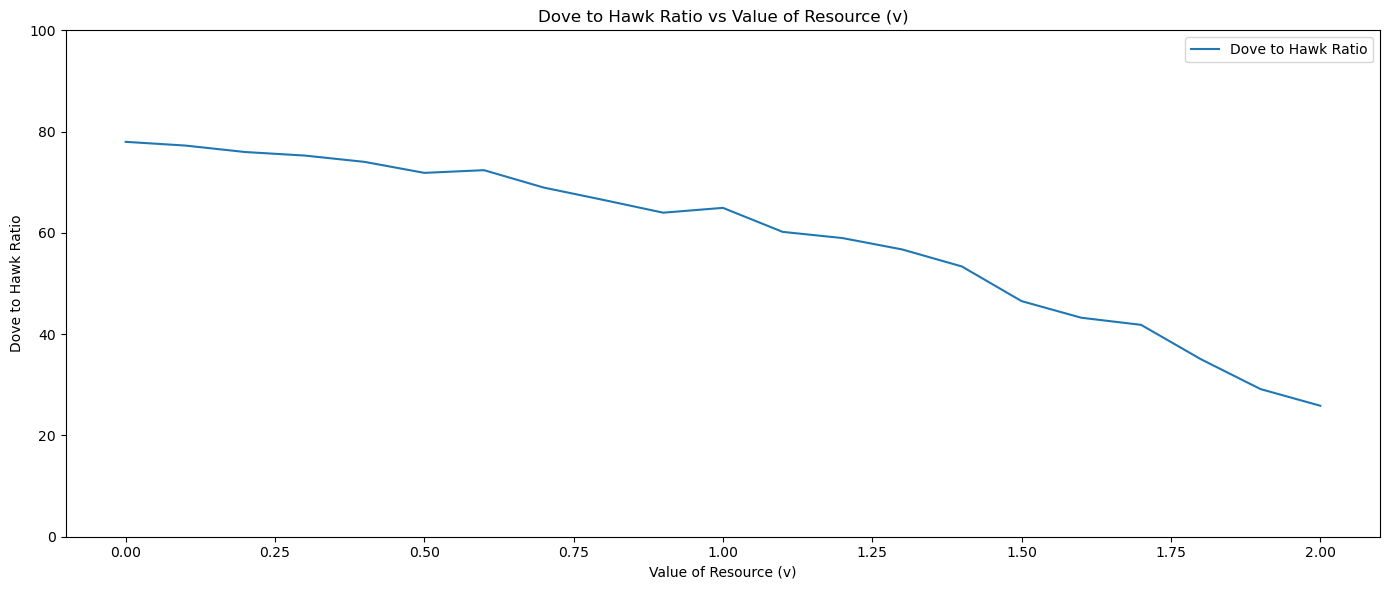

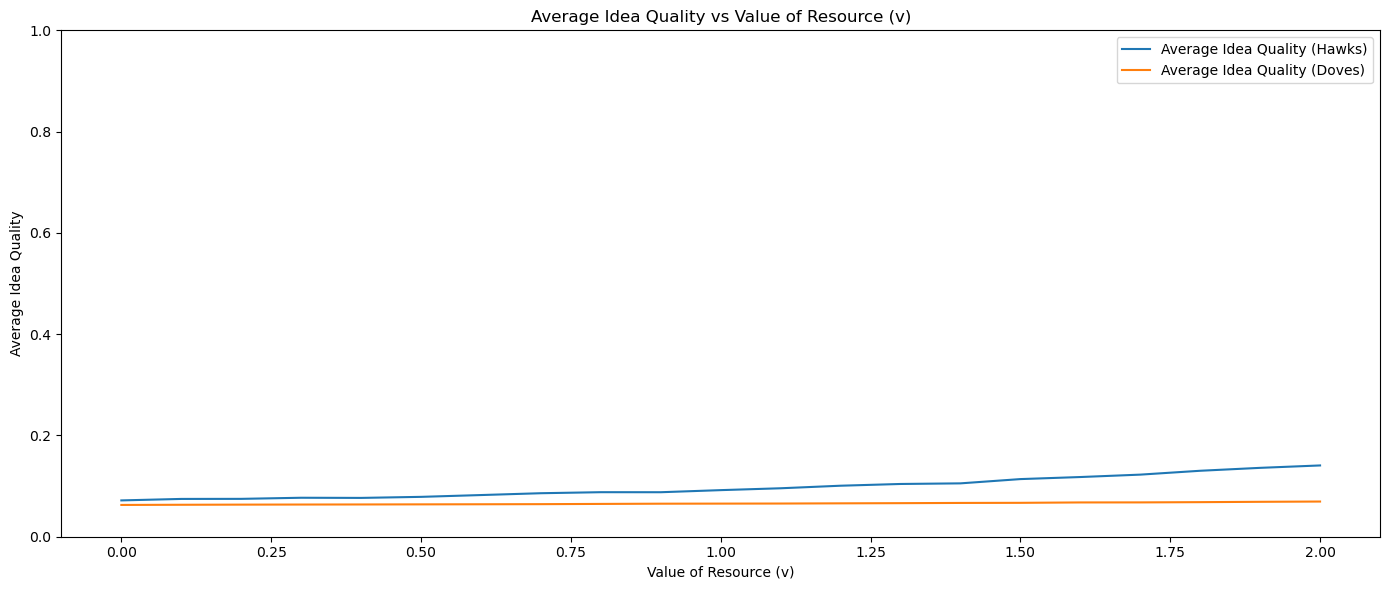

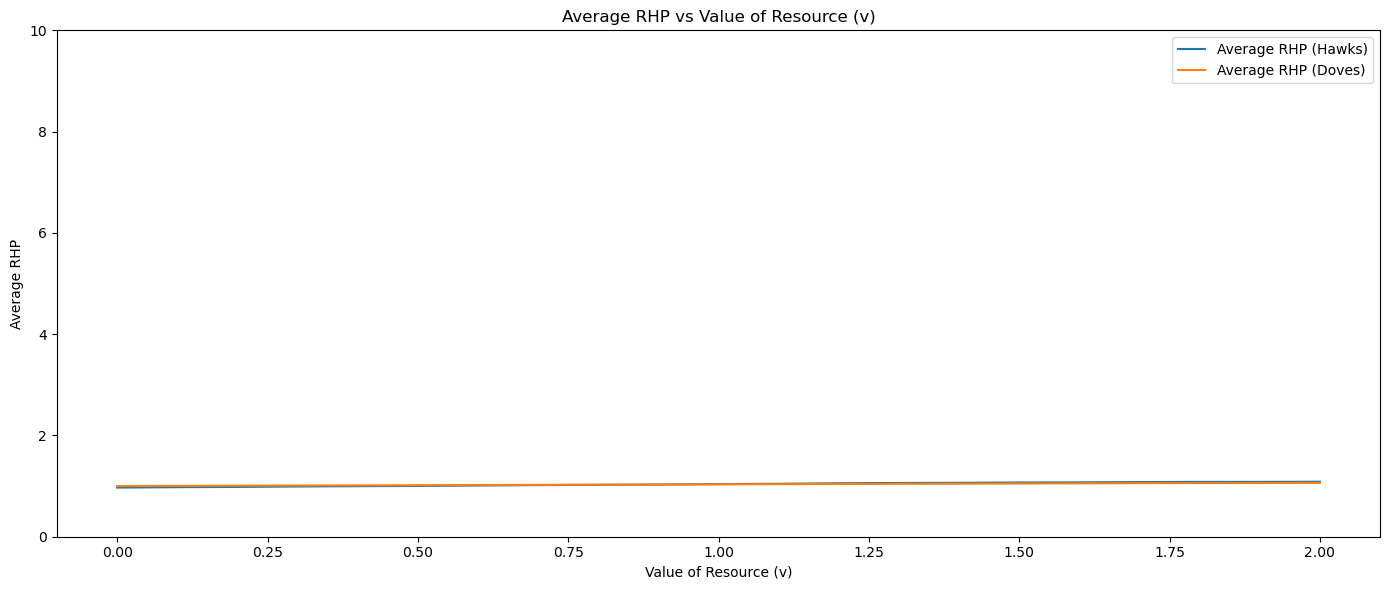

In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


class Parameters:
    def __init__(self, num_agents, hawk_ratio, dove_ratio, v, c, initial_RHP, min_RHP_threshold):
        self.num_agents = num_agents
        self.hawk_ratio = hawk_ratio
        self.dove_ratio = dove_ratio
        self.v = v
        self.c = c
        self.initial_RHP = initial_RHP
        self.min_RHP_threshold = min_RHP_threshold


class Bird:
    def __init__(self, strategy, parameters):
        self.parameters = parameters
        self.strategy = strategy
        self.RHP = parameters.initial_RHP
        self.idea = [random.uniform(0, 1)]

    def evaluate_idea(self):
        return np.mean(self.idea)

    def share_ideas(self, other):
        if self.strategy == other.strategy == "dove":
            avg_idea = 0.5 * (self.idea[0] + other.idea[0])
            self.idea[0] = avg_idea
            other.idea[0] = avg_idea

    def contest(self, opponent):
        if self.strategy == "hawk" and opponent.strategy == "hawk":
            winner = random.choice([self, opponent])
            winner.RHP += self.parameters.v * winner.evaluate_idea() - self.parameters.c
            loser = self if winner is opponent else opponent
            loser.RHP -= self.parameters.c
        elif self.strategy == "hawk":
            self.RHP += self.parameters.v * self.evaluate_idea()
        elif opponent.strategy == "hawk":
            opponent.RHP += self.parameters.v * opponent.evaluate_idea()
        else:
            self.RHP += self.parameters.v * self.evaluate_idea() / 2
            opponent.RHP += self.parameters.v * opponent.evaluate_idea() / 2

        self.RHP = max(self.parameters.min_RHP_threshold, self.RHP)
        opponent.RHP = max(self.parameters.min_RHP_threshold, opponent.RHP)

    def mutate_strategy(self):
        mutation_rate = 0.001  # 5% chance of mutation
        if random.random() < mutation_rate:
            self.strategy = "dove" if self.strategy == "hawk" else "hawk"

    def spawn(self):
        offspring = Bird(self.strategy, self.parameters)
        offspring.idea = [idea + random.uniform(-0.1, 0.1) for idea in self.idea]
        offspring.idea = [max(min(idea, 1), 0) for idea in offspring.idea]
        offspring.mutate_strategy()
        return offspring


class Model:
    def __init__(self, parameters):
        self.parameters = parameters
        self.hawks = []
        self.doves = []
        self.avg_idea_hawks = []
        self.avg_idea_doves = []
        self.avg_RHP_hawks = []
        self.avg_RHP_doves = []

    def initialize_population(self):
        self.birds = []
        for _ in range(self.parameters.num_agents):
            strategy = random.choices(["hawk", "dove"], [self.parameters.hawk_ratio, self.parameters.dove_ratio])[0]
            self.birds.append(Bird(strategy, self.parameters))

    def full_inheritance(self):
        weights = [bird.RHP for bird in self.birds]
        weights = np.array(weights) / np.sum(weights)
        offspring_counts = np.random.multinomial(self.parameters.num_agents, weights)
        self.birds = [self.birds[i].spawn() for i, count in enumerate(offspring_counts) for _ in range(count)]

    def record_stats(self):
        self.hawks.append(sum(bird.strategy == "hawk" for bird in self.birds))
        self.doves.append(sum(bird.strategy == "dove" for bird in self.birds))
        avg_idea_hawk = np.mean([bird.evaluate_idea() for bird in self.birds if bird.strategy == "hawk"])
        avg_idea_dove = np.mean([bird.evaluate_idea() for bird in self.birds if bird.strategy == "dove"])
        self.avg_idea_hawks.append(avg_idea_hawk)
        self.avg_idea_doves.append(avg_idea_dove)
        avg_RHP_hawk = np.mean([bird.RHP for bird in self.birds if bird.strategy == "hawk"])
        avg_RHP_dove = np.mean([bird.RHP for bird in self.birds if bird.strategy == "dove"])
        self.avg_RHP_hawks.append(avg_RHP_hawk)
        self.avg_RHP_doves.append(avg_RHP_dove)

    def step(self):
        self.full_inheritance()
        pairs = np.random.choice(len(self.birds), (len(self.birds) // 2, 2), replace=False)
        for i, j in pairs:
            self.birds[i].share_ideas(self.birds[j])
            self.birds[i].contest(self.birds[j])

        decay_rate = 0.1
        for bird in self.birds:
            bird.idea = [idea * (1 - decay_rate) for idea in bird.idea]

        self.record_stats()

    def simulate(self, num_steps):
        for _ in range(num_steps):
            self.step()


# Parameter sweep
parameter_sweep = []
total_iterations = len(np.arange(0, 2.1, 0.1)) * 10

for v in tqdm(np.arange(0, 2.1, 0.1), desc="Running simulations"):
    for _ in range(10):
        parameters = Parameters(100, 0.5, 0.5, v, 1, 1, 0.1)
        model = Model(parameters)
        model.initialize_population()
        model.simulate(5000)
        df_stats = pd.DataFrame({
            'n_hawks': model.hawks,
            'n_doves': model.doves,
            'avg_idea_hawks': model.avg_idea_hawks,
            'avg_idea_doves': model.avg_idea_doves,
            'avg_RHP_hawks': model.avg_RHP_hawks,
            'avg_RHP_doves': model.avg_RHP_doves,
            'v': v
        })
        parameter_sweep.append(df_stats)

df = pd.concat(parameter_sweep)

# Plotting
plt.figure(figsize=(14, 6))

df['dove_hawk_ratio'] = df['n_doves'] / df['n_hawks'].replace(0, 1)
df.groupby('v')['dove_hawk_ratio'].mean().plot(label='Dove to Hawk Ratio')
plt.title('Dove to Hawk Ratio vs Value of Resource (v)')
plt.xlabel('Value of Resource (v)')
plt.ylabel('Dove to Hawk Ratio')
plt.ylim(0, 100)  # Set y-axis limits

plt.legend()
plt.tight_layout()
plt.savefig('dove_hawk_ratio.png')  # Save the plot
plt.show()

# Plotting average idea quality
plt.figure(figsize=(14, 6))

df.groupby('v')['avg_idea_hawks'].mean().plot(label='Average Idea Quality (Hawks)')
df.groupby('v')['avg_idea_doves'].mean().plot(label='Average Idea Quality (Doves)')
plt.title('Average Idea Quality vs Value of Resource (v)')
plt.xlabel('Value of Resource (v)')
plt.ylabel('Average Idea Quality')
plt.ylim(0, 1)  # Set y-axis limits to idea quality range

plt.legend()
plt.tight_layout()
plt.savefig('avg_idea_quality.png')  # Save the plot
plt.show()

# Plotting average RHP values
plt.figure(figsize=(14, 6))

df.groupby('v')['avg_RHP_hawks'].mean().plot(label='Average RHP (Hawks)')
df.groupby('v')['avg_RHP_doves'].mean().plot(label='Average RHP (Doves)')
plt.title('Average RHP vs Value of Resource (v)')
plt.xlabel('Value of Resource (v)')
plt.ylabel('Average RHP')
plt.ylim(0, 10)  # Set y-axis limits for RHP

plt.legend()
plt.tight_layout()
plt.savefig('avg_RHP.png')  # Save the plot
plt.show()